In [33]:
import numpy as np 
import matplotlib.pyplot as plt  
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal, TransformedDistribution, Independent
from pyro.distributions.transforms import AffineAutoregressive

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)

Using device: mps


In [34]:
transform = transforms.Compose([
    transforms.Resize((7,7)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [35]:
input_dim = 7 * 7  # 49
base_distribution = Independent(
    Normal(torch.zeros(input_dim, device=device), torch.ones(input_dim, device=device)), 
    1
)

In [36]:
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super().__init__()
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det = -((1 - self.mask) * s).sum(dim=1)
        return x, log_det

class CouplingFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            mask = self.create_mask(input_dim, even=(i % 2 == 0))
            self.layers.append(CouplingLayer(input_dim, hidden_dim, mask))
    
    def create_mask(self, dim, even=True):
        mask = torch.zeros(dim)
        if even:
            mask[:dim//2] = 1
        else:
            mask[dim//2:] = 1
        return mask.to(device)
    
    def forward(self, x):
        log_det_total = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total
    
    def inverse(self, z):
        log_det_total = 0
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_total += log_det
        return z, log_det_total

In [37]:
class AutoregressiveNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * input_dim)
        )
    def forward(self, x):
        out = self.net(x)
        shift, log_scale = out.chunk(2, dim=1)
        return shift, log_scale

class AutoregressiveFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.transforms = nn.ModuleList()
        for _ in range(n_layers):
            arn = AutoregressiveNN(input_dim, hidden_dim)
            self.transforms.append(AffineAutoregressive(arn))
        self.input_dim = input_dim
        self.base_dist = Independent(
            Normal(torch.zeros(input_dim, device=device),
                   torch.ones(input_dim, device=device)),
            1
        )
    
    def forward(self, x):
        log_det_total = 0
        for transform in self.transforms:
            y = transform(x)
            log_det = transform.log_abs_det_jacobian(x, y).sum(dim=-1)
            x = y
            log_det_total += log_det
        return x, log_det_total
    
    def inverse(self, z):
        log_det_total = 0
        for transform in reversed(self.transforms):
            x = transform.inv(z)
            log_det = -transform.log_abs_det_jacobian(x, z).sum(dim=-1)
            z = x
            log_det_total += log_det
        return z, log_det_total
    
    def log_prob(self, x):
        z, log_det = self.forward(x)
        return self.base_dist.log_prob(z) + log_det
    
    def sample(self, num_samples):
        z = self.base_dist.sample((num_samples,))
        x, _ = self.inverse(z)
        return x

In [38]:
def train_flow(model, optimizer, data_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch, _ in data_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            if isinstance(model, CouplingFlow):
                z, log_det = model(batch)
                log_prob = base_distribution.log_prob(z) + log_det
            else:
                log_prob = model.log_prob(batch)
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
        avg_loss = total_loss / len(data_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

def evaluate_flow(model, data_loader):
    model.eval()
    total_log_prob = 0
    with torch.no_grad():
        for batch, _ in data_loader:
            batch = batch.to(device)
            if isinstance(model, CouplingFlow):
                z, log_det = model(batch)
                log_prob = base_distribution.log_prob(z) + log_det
            else:
                log_prob = model.log_prob(batch)
            total_log_prob += log_prob.sum().item()
    avg_log_prob = total_log_prob / len(data_loader.dataset)
    return avg_log_prob

In [40]:
hidden_dim = 128
n_layers = 4

coupling_flow = CouplingFlow(input_dim, hidden_dim, n_layers).to(device)
auto_flow = AutoregressiveFlow(input_dim, hidden_dim, n_layers).to(device)

optimizer_coupling = optim.Adam(coupling_flow.parameters(), lr=1e-3)
optimizer_auto = optim.Adam(auto_flow.parameters(), lr=1e-3)

print("Training Coupling Flow:")
train_flow(coupling_flow, optimizer_coupling, train_loader, epochs=3)

print("\nTraining Autoregressive Flow:")
train_flow(auto_flow, optimizer_auto, train_loader, epochs=3)

coupling_ll = evaluate_flow(coupling_flow, test_loader)
auto_ll = evaluate_flow(auto_flow, test_loader)

print("\nTest Log-Likelihood:")
print("Coupling Flow:", coupling_ll)
print("Autoregressive Flow:", auto_ll)

Training Coupling Flow:
Epoch 1, Loss: -38.5988
Epoch 2, Loss: -49.2361
Epoch 3, Loss: -50.1832

Training Autoregressive Flow:
Epoch 1, Loss: -14580.0693
Epoch 2, Loss: -25621.8067
Epoch 3, Loss: -29992.3396

Test Log-Likelihood:
Coupling Flow: 50.51857679443359
Autoregressive Flow: 31586.46613125


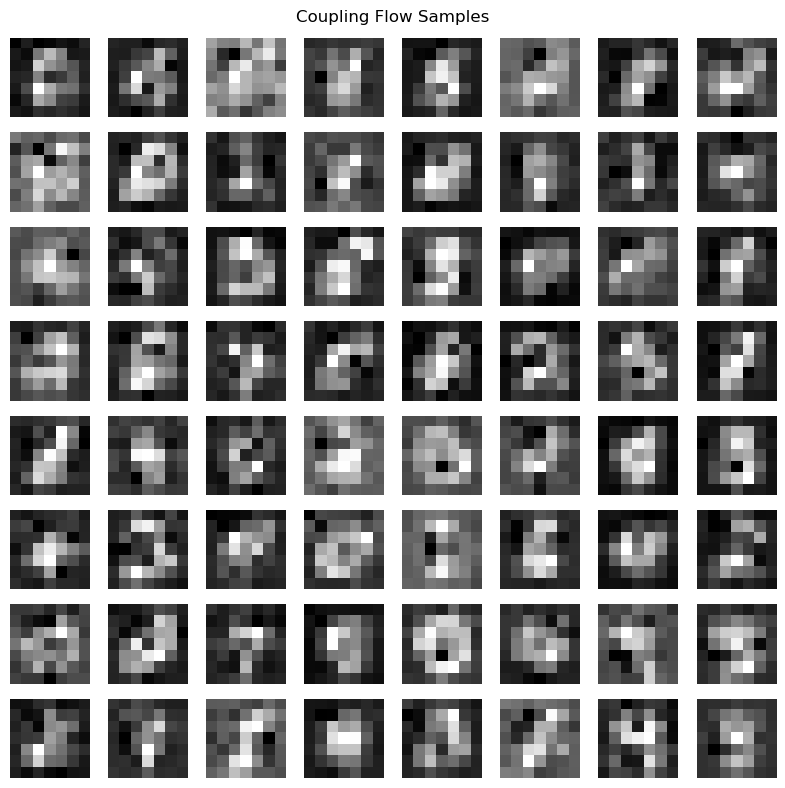

AttributeError: 'AutoregressiveNN' object has no attribute 'permutation'

In [41]:
def plot_samples(samples, title):
    samples = samples.view(-1, 7, 7).cpu().numpy()
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Coupling Flow samples
with torch.no_grad():
    z = base_distribution.sample((64,))
    x_samples, _ = coupling_flow.inverse(z)
plot_samples(x_samples, "Coupling Flow Samples")

# Autoregressive Flow samples
with torch.no_grad():
    x_samples_auto = auto_flow.sample(64)
plot_samples(x_samples_auto, "Autoregressive Flow Samples")